<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/BBU_UN_Price_Forecasting_with_yfinance_and_Facebook_Prophet_May_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 18.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Importing the Dataset & Exploring it

In [35]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BBU-UN.TO
You entered BBU-UN.TO, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
744,2022-05-06,29.000000,30.610001,29.000000,29.900000,63700,0.0,0
745,2022-05-09,29.650000,29.969999,29.299999,29.440001,82000,0.0,0
746,2022-05-10,30.040001,30.170000,29.049999,29.309999,80500,0.0,0
747,2022-05-11,30.000000,30.790001,29.559999,30.250000,61700,0.0,0
748,2022-05-12,29.790001,30.580000,29.290001,29.480000,72100,0.0,0
749,2022-05-13,29.549999,30.540001,29.549999,30.129999,61300,0.0,0
750,2022-05-16,30.290001,30.950001,29.370001,29.750000,97700,0.0,0
751,2022-05-17,30.389999,30.670000,29.730000,30.250000,61000,0.0,0
752,2022-05-18,30.240000,30.240000,28.389999,28.639999,87200,0.0,0
753,2022-05-19,28.250000,28.570000,27.920000,28.040001,17736,0.0,0


In [36]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.0
mean,49.341187,50.039408,48.614248,49.326955,71511.851459,0.000110,0.0
std,7.739311,7.621723,7.821185,7.768296,64682.162255,0.003023,0.0
min,28.010000,28.570000,27.000000,27.790001,4000.000000,0.000000,0.0
25%,43.237501,44.116420,42.413178,43.257500,32525.000000,0.000000,0.0
50%,51.020086,51.509369,50.430949,50.972576,52500.000000,0.000000,0.0
75%,55.007499,55.537118,54.462516,55.047500,84050.000000,0.000000,0.0
max,64.099998,65.349998,63.259998,64.000000,675400.000000,0.083000,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [37]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [38]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [39]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [40]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [41]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [42]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 2)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [43]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
749,2022-05-13,30.129999
750,2022-05-16,29.750000
751,2022-05-17,30.250000
752,2022-05-18,28.639999
753,2022-05-19,28.040001


## Creating Facebook Prophet Model

In [44]:
m=Prophet(yearly_seasonality=True)
m.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##Forecasting

In [45]:
periods = 30
future=m.make_future_dataframe(periods)

In [46]:
forecast=m.predict(future)

In [47]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-05-21,53.601795,46.749005,53.218141,53.601795,53.601795,-3.633803,-3.633803,-3.633803,0.549232,0.549232,0.549232,-4.183035,-4.183035,-4.183035,0.0,0.0,0.0,49.967992
1,2019-05-22,53.576783,46.857321,53.533567,53.576783,53.576783,-3.503151,-3.503151,-3.503151,0.562069,0.562069,0.562069,-4.065220,-4.065220,-4.065220,0.0,0.0,0.0,50.073632
2,2019-05-23,53.551771,46.925663,53.316102,53.551771,53.551771,-3.431318,-3.431318,-3.431318,0.516171,0.516171,0.516171,-3.947489,-3.947489,-3.947489,0.0,0.0,0.0,50.120454
3,2019-05-24,53.526760,46.780432,53.324624,53.526760,53.526760,-3.343662,-3.343662,-3.343662,0.486685,0.486685,0.486685,-3.830347,-3.830347,-3.830347,0.0,0.0,0.0,50.183098
4,2019-05-27,53.451725,47.275600,53.801702,53.451725,53.451725,-2.840637,-2.840637,-2.840637,0.646042,0.646042,0.646042,-3.486680,-3.486680,-3.486680,0.0,0.0,0.0,50.611087
5,2019-05-28,53.426713,47.109490,53.743627,53.426713,53.426713,-2.826652,-2.826652,-2.826652,0.549232,0.549232,0.549232,-3.375885,-3.375885,-3.375885,0.0,0.0,0.0,50.600061
6,2019-05-29,53.401701,47.527651,54.143725,53.401701,53.401701,-2.705394,-2.705394,-2.705394,0.562069,0.562069,0.562069,-3.267463,-3.267463,-3.267463,0.0,0.0,0.0,50.696307
7,2019-05-30,53.376689,47.353391,54.152116,53.376689,53.376689,-2.645498,-2.645498,-2.645498,0.516171,0.516171,0.516171,-3.161669,-3.161669,-3.161669,0.0,0.0,0.0,50.731191
8,2019-05-31,53.351678,47.495007,54.156325,53.351678,53.351678,-2.572050,-2.572050,-2.572050,0.486685,0.486685,0.486685,-3.058736,-3.058736,-3.058736,0.0,0.0,0.0,50.779628
9,2019-06-03,53.276643,47.649335,54.456297,53.276643,53.276643,-2.123158,-2.123158,-2.123158,0.646042,0.646042,0.646042,-2.769200,-2.769200,-2.769200,0.0,0.0,0.0,51.153485


In [48]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

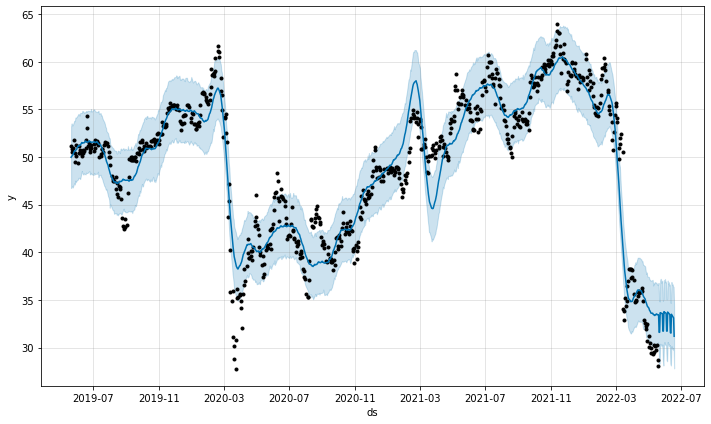

In [49]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

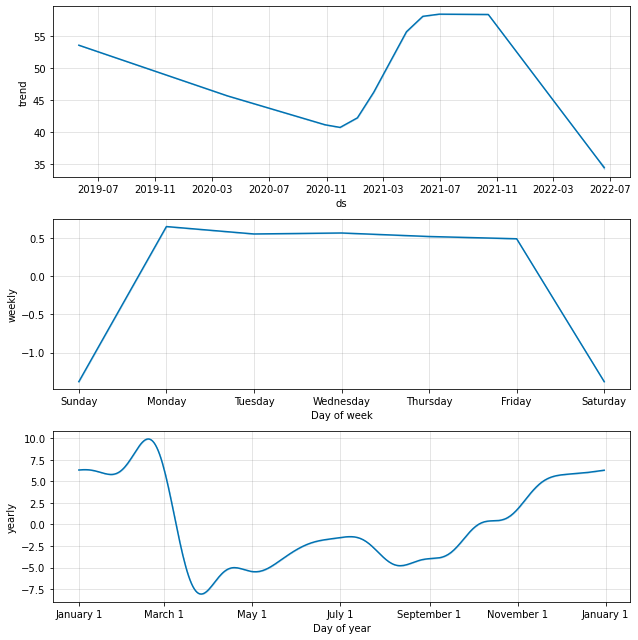

In [50]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [51]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>